# Validating timezone regularity
Given that the distributions were not uniform and some individuals appeared to have their peak meal intake distribution visibly shifted to a period overnight, it makes sense to check the timezones of the individuals. There is possible validation between the timezone of datetime values for records in the files and the region held in the profile file, which can translate to a timezone. The first check is to see whether people have multiple timezones for datetime values across the records in the files. This should focus on the single datetime column in each file that is used for the time series in the processed data, rather than a generic approach to all timestamp columns. This is relevant to the device status files where we know that columns do not align in their timestamps. Some are localised to UTC while others keep the timezone offset, in the same dataset. The existence of two timezones in the time series column may be justified, but it might also be introduced through error. Either way, it needs checking and possibly eliminating the individuals by default. The second check is to see whether the timezone of the datetime values matches the timezone of the region in the profile file. The second check is to see whether the timezone of the datetime values matches the timezone of the region in the profile file. These should align. The check is done by translating the profile region to a timezone and for both this and the record timestamps to have their UTC offset compared, which makes comparison similar.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from src.data_processing.read import get_all_offsets_df_from_profiles
from src.configurations import Configuration
from src.config import INTERIM_DATA_DIR

config = Configuration()

df_offsets = get_all_offsets_df_from_profiles(config)
df_regions = (pd.read_csv(config.profile_regions_csv_file)
              .drop(columns=["Unnamed: 0","defaultProfile"])
              .drop_duplicates()
              .set_index("id", drop=True))
df_regions.head()

2025-08-18 22:33:39.621 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


2025-08-18 22:33:41.279 | INFO     | src.data_processing.read:read_zip_file:124 - Reading 00221634
2025-08-18 22:33:48.428 | INFO     | src.data_processing.read:read_zip_file:124 - Reading 00309157
2025-08-18 22:35:39.751 | INFO     | src.data_processing.read:read_zip_file:124 - Reading 00897741
2025-08-18 22:37:06.289 | INFO     | src.data_processing.read:read_zip_file:124 - Reading 01352464
2025-08-18 22:39:28.013 | INFO     | src.data_processing.read:read_zip_file:124 - Reading 02033176
2025-08-18 22:40:21.444 | INFO     | src.data_processing.read:read_zip_file:124 - Reading 02199852


KeyboardInterrupt: 

In [42]:
df_offset_count = df_offsets.groupby('id').count()
df_offset_count.reset_index().groupby('offset')['id'].count()

offset
1    83
2    23
3     5
4     1
5     1
Name: id, dtype: int64

In [43]:
id_ = 41131654
df_regions.loc[id_]

tz        Pacific/Auckland
offset                  12
Name: 41131654, dtype: object

We need a list of all the individuals with single offsets so these can be applied consistently to the data.

None of the openaps/enacted/timestamp columns appeared to have issues in the read, but given that we don't need those datetime columns in the device status files that had different timezone values, we should just address the timezones in the openaps/enacted/timestamp column.

Now we need to have a look at how the offset might be affecting the individual above. Lets look at the data in more depth.

In [ ]:
from src.config import INTERIM_DATA_DIR
from src.data_processing.read_preprocessed_df import ReadPreprocessedDataFrame, apply_and_filter_by_offsets
from src.configurations import FifteenMinute

df_origin = pd.read_parquet(INTERIM_DATA_DIR / 'device_status_df_tz_naive.parquet')

df_origin['id'] = df_origin['id'].astype('int')
cols = ['id'] + df_origin.select_dtypes(include=['datetime64[ns]']).columns.tolist()
df_origin = df_origin[cols].set_index(['id', 'datetime']).dropna(axis=0, how='all').sort_index()
df_origin = df_origin.loc[id_]
df_origin.head()

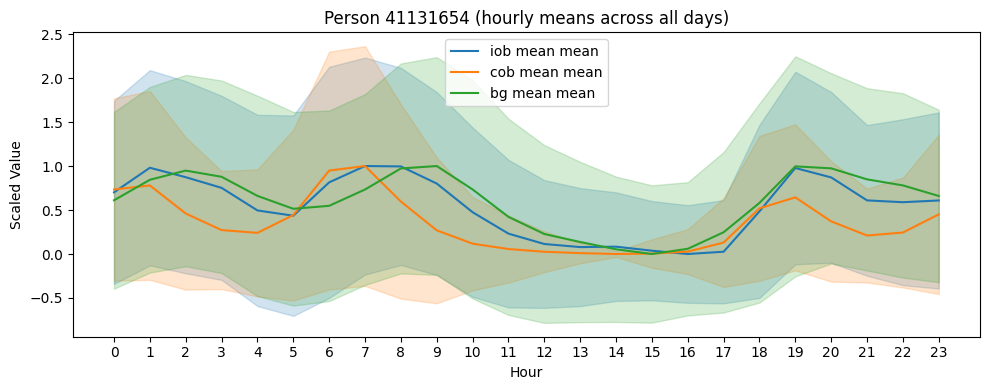

In [66]:
df_processed = ReadPreprocessedDataFrame(FifteenMinute(), file_type='parquet').df
df_individual = df_processed.xs(id_, level='id')

from src.time_series_analysis import plot_hourly_means_for_individual

plot_hourly_means_for_individual(df=df_individual, zip_id=id_)

This is the raw data. Now if apply the offsets, this should change.

In [67]:
print('Before')
print(df_individual.head().index)
df_individual = df_individual.copy()
df_individual.loc[:, 'id'] = id_
df_individual = (df_individual
                 .reset_index()
                 .set_index(['id','datetime'], drop=True))

Before
DatetimeIndex(['2019-08-31 13:15:00', '2019-08-31 18:00:00',
               '2019-08-31 18:15:00', '2019-08-31 18:45:00',
               '2019-08-31 19:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


In [68]:
from src.data_processing.read_preprocessed_df import apply_and_filter_by_offsets

df_single_offsets = df_offsets[~df_offsets.duplicated('id', keep=False)].set_index('id')
df_adjusted = apply_and_filter_by_offsets(interim_df=df_individual, offsets_df=df_single_offsets)
df_adjusted.head().index


MultiIndex([(41131654, '2019-09-01 01:15:00'),
            (41131654, '2019-09-01 06:00:00'),
            (41131654, '2019-09-01 06:15:00'),
            (41131654, '2019-09-01 06:45:00'),
            (41131654, '2019-09-01 07:00:00')],
           names=['id', 'datetime'])

And finally, lets see how that has impacted the times.

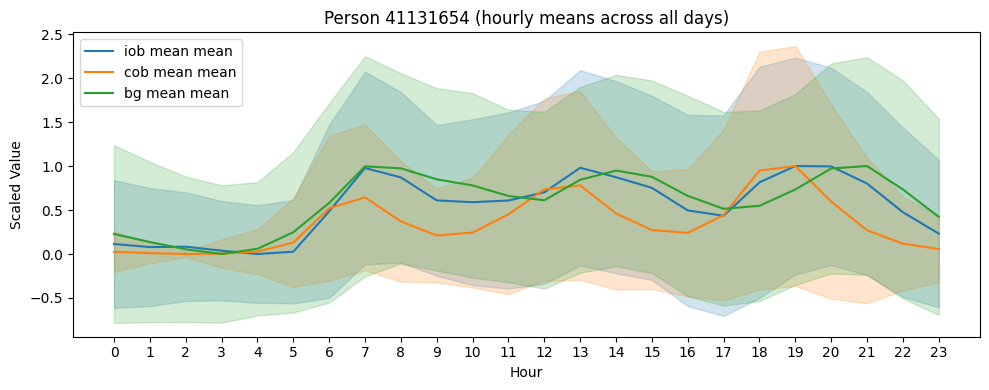

In [69]:
plot_hourly_means_for_individual(df_adjusted, zip_id=id_)